In [28]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from typing import Literal
from sklearn import manifold
from scipy.spatial import distance_matrix

In [29]:
import utils

In [30]:
def affinity_matrix(W, n_neighbors=20, alpha=1.0):
    nn_max = np.mean(np.sort(W)[:, n_neighbors + 1])
    eps = 2 * nn_max ** 2

    # Kernel matrix
    K = np.exp(-(W ** 2) / eps)
    # alpha_norm = K.sum(axis=1) ** alpha
    # K /= alpha_norm
    # K /= alpha_norm[:, None]
    return K

In [31]:
def cmp_dist_matrices(W1, W2, mode: Literal['l1_norm', 'nearest_neighbors', 'ranked_nearest_neighbors'], n_neighbors: int = 20):
    if mode == "ranked_nearest_neighbors":
        delta = np.argsort(np.argsort(W1, axis=1), axis=1) - np.argsort(np.argsort(W2, axis=1), axis=1)
        res = np.sum(np.abs(delta[:,:n_neighbors+1]))
        return res
    elif mode == "nearest_neighbors":
        l1 = np.argsort(W1, axis=1)[:,:n_neighbors+1]
        l2 = np.argsort(W2, axis=1)[:,:n_neighbors+1]
        res = 0
        for x, y in zip(l1, l2):
            res += len(set(x).symmetric_difference(set(y)))
        return res
    elif mode == "l1_norm":
        W1_normed = W1 / np.linalg.norm(W1, ord=1)
        W2_normed = W1 / np.linalg.norm(W2, ord=1)
        res = np.linalg.norm(W1_normed - W2_normed, ord=1)
        return res

In [32]:
def process(data, cmp_mode: Literal['l1_norm', 'nearest_neighbors', 'ranked_nearest_neighbors'], n_neighbors: int = 100, n_components_tried: int = 20):
    W = utils.gen_dist_matrix(data)
    scores = []
    for n_components in range(1, n_components_tried + 1):
        aff_matrix = affinity_matrix(W, n_neighbors=n_neighbors)
        model = manifold.SpectralEmbedding(n_components=n_components, affinity="precomputed")
        embedding = model.fit_transform(aff_matrix)
        W_embedded = distance_matrix(embedding, embedding)
        score = cmp_dist_matrices(W, W_embedded, cmp_mode, n_neighbors)
        scores.append(score)
    return scores

In [33]:
comps_range = range(1, 21)

def full_run(experiment_name: str, expected_embed_size: int, n_neighbors: int = 100):
    data = utils.get_data(experiment_name)

    # L1
    scores = process(data, "l1_norm", n_neighbors)
    plt.figure()
    plt.scatter(comps_range, scores)
    plt.title(f"L1. {experiment_name}. Expected embed size: {expected_embed_size}")
    plt.xlabel("Number of conserved quantities")
    plt.ylabel("L1 norm diff of distance matrices ")
    plt.xticks(comps_range)

    # Neighbors
    scores = process(data, "nearest_neighbors", n_neighbors)
    plt.figure()
    plt.scatter(comps_range, scores)
    plt.title(f"Neighbors. {experiment_name}. Expected embed size: {expected_embed_size}")
    plt.xlabel("Number of conserved quantities")
    plt.ylabel("Set symmetric difference of nearest neighbors")
    plt.xticks(comps_range)

    # Ranked neighbors
    scores = process(data, "ranked_nearest_neighbors", n_neighbors)
    plt.figure()
    plt.scatter(comps_range, scores)
    plt.title(f"Distance matrices. {experiment_name}. Expected embed size: {expected_embed_size}")
    plt.xlabel("Number of conserved quantities")
    plt.ylabel("Rank difference of nearest neighbors")
    plt.xticks(comps_range)

## Results

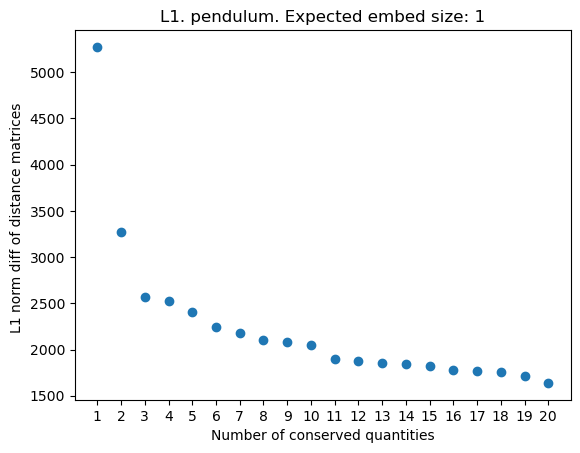

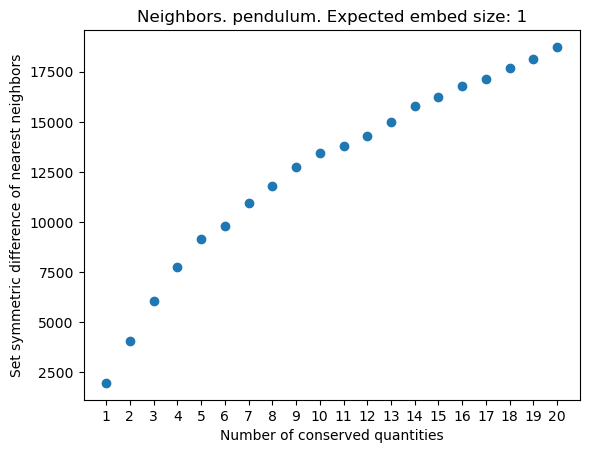

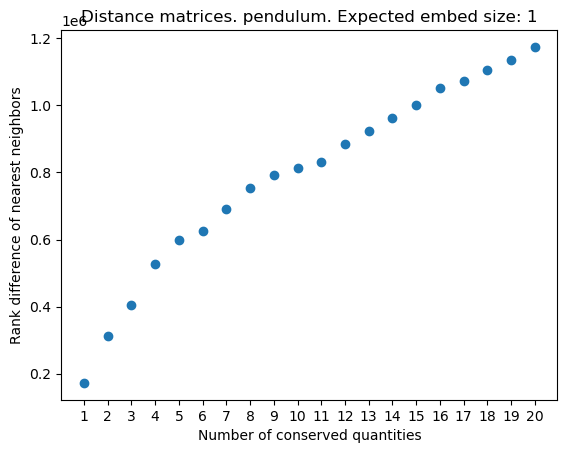

In [34]:
full_run("pendulum", 1)

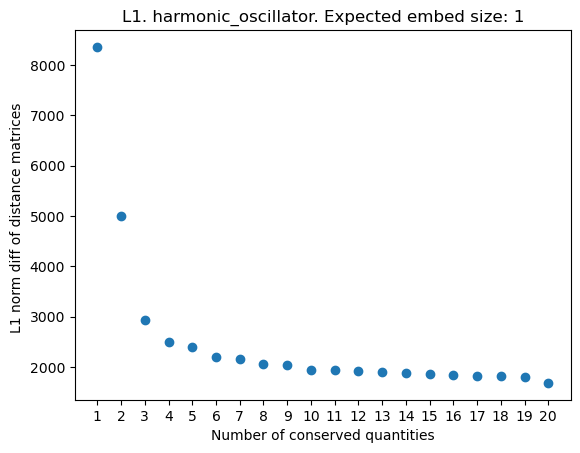

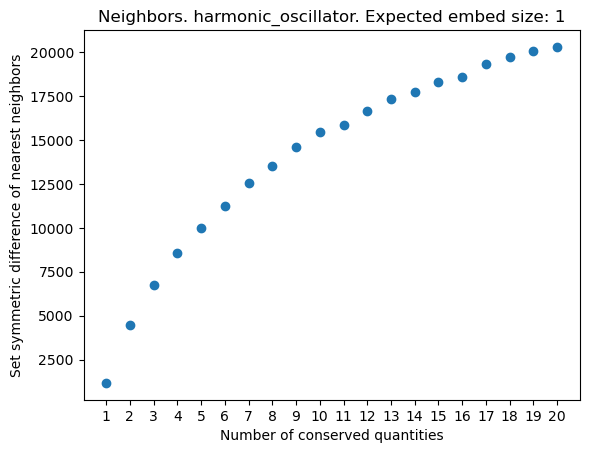

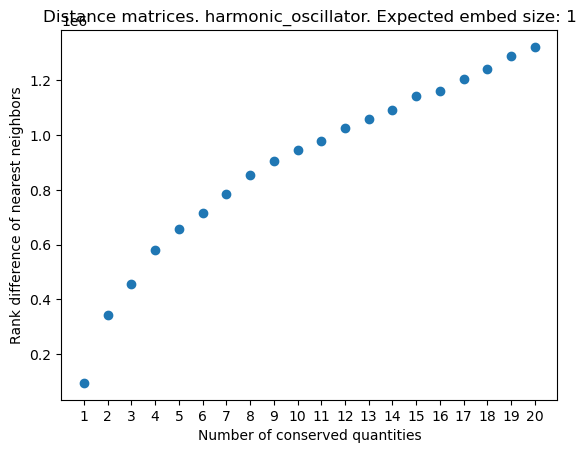

In [35]:
full_run("harmonic_oscillator", 1)

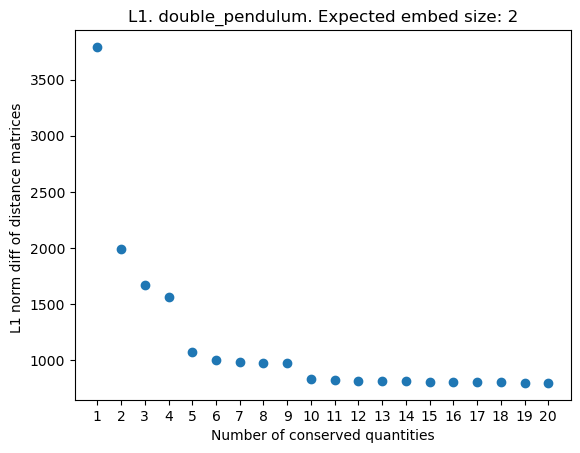

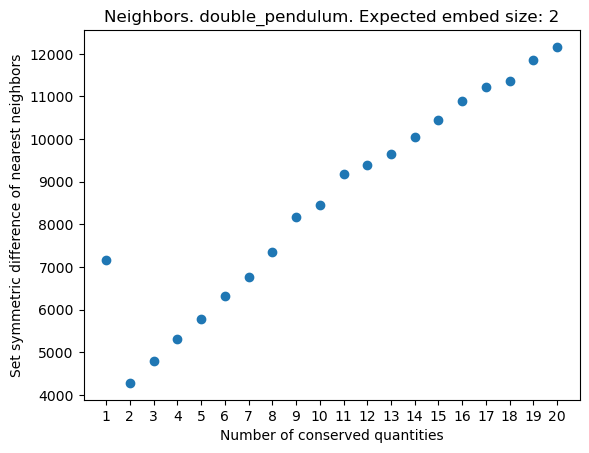

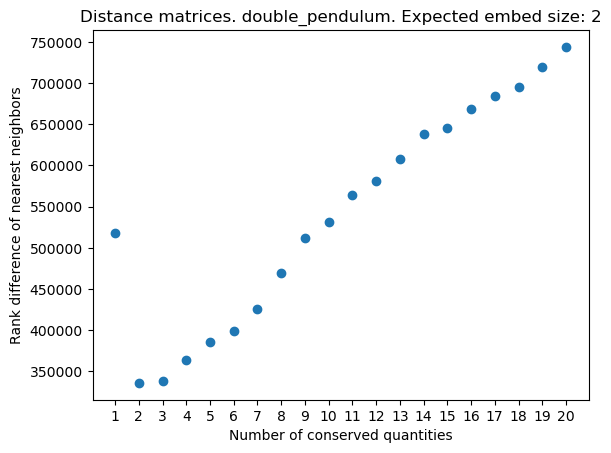

In [36]:
full_run("double_pendulum", 2)

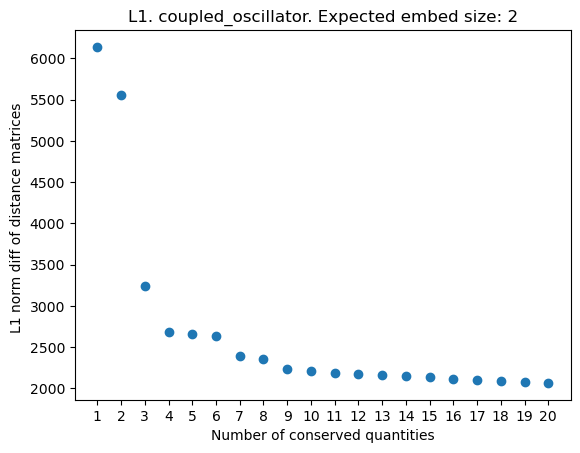

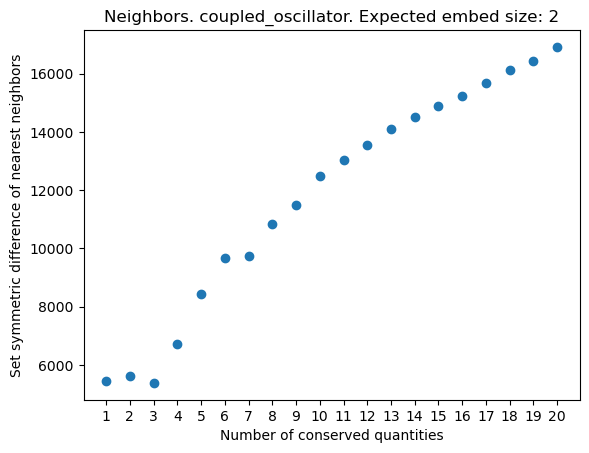

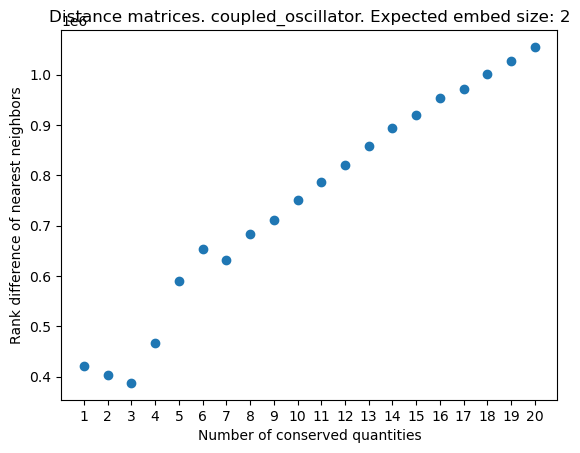

In [37]:
full_run("coupled_oscillator", 2)

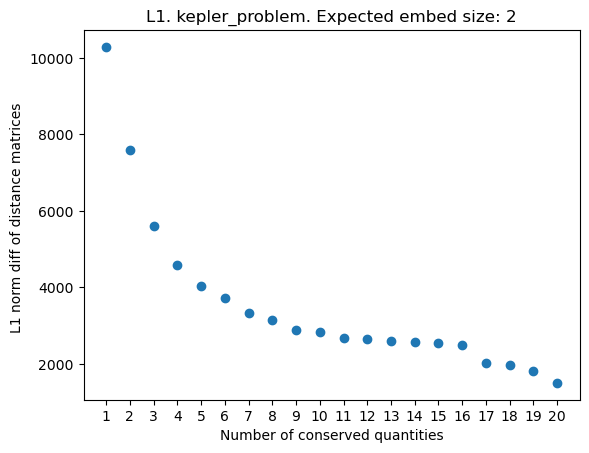

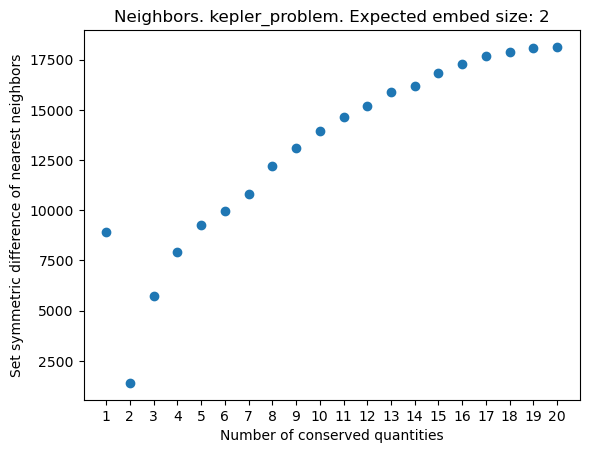

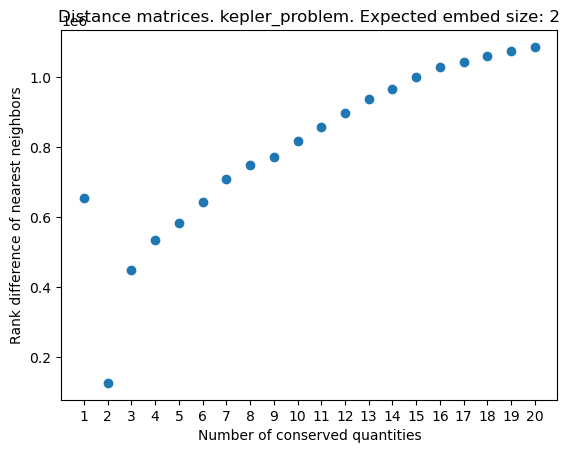

In [38]:
full_run("kepler_problem", 2)